In [1]:
from itertools import zip_longest
from math import sqrt, factorial, pi, exp
import numpy as np
from scipy.special import erf, erfinv
from utils.inverse_cdf import InverseCDF

In [2]:
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle, Arc
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 10

legend_opts = {
    'fontsize':15,
    'frameon':True, 
    'framealpha':1,
    'facecolor':'white',
    'edgecolor':'black',
    'labelspacing':0.1}

def savefig(fig, filename, **kwargs):
    fig.savefig(f'../viz/{filename}', bbox_inches='tight', **kwargs)

Plot for outline of PPT

In [4]:
rng = np.random.RandomState(42)
xs = rng.standard_normal(size=500)
ys = rng.standard_normal(size=500)
L = np.array([[-1.85882053, -0.73809637],
       [-1.45132321,  0.94533641]])
L2 = np.linalg.cholesky(np.array([[1, -2], [-2, 8]]))
transformed_xs, transformed_ys = np.array([7, 9])[:, np.newaxis] + L @ np.array([xs, ys])
transformed_xs2, transformed_ys2 = np.array([-10, -3])[:, np.newaxis] + L2 @ np.array([xs, ys])

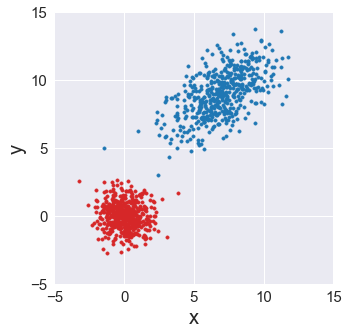

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(xs, ys, marker='.', color='tab:red')
ax.scatter(transformed_xs, transformed_ys, marker='.', color='tab:blue')
# ax.scatter(transformed_xs2, transformed_ys2, marker='.', color='tab:green')

ax.set_xlim(-5, 15)
ax.set_ylim(-5, 15)
ax.set_yticks(range(-5, 16, 5))
ax.set_xlabel('x')
ax.set_ylabel('y')
savefig(fig, 'intro_plot.png')

# Inversion sampling

## Relationship between CDF and PDF of a distribution

In [6]:
def cdf(z):
    '''Standard Gaussian CDF using scipy.special.erf function
    Tansform sample z to left-side area / cumulative probability'''
    return 0.5 + 0.5*erf(z/sqrt(2))

In [7]:
def pdf(z):
    '''Standard Gaussian PDF
    Transform sample z to density at that point'''
    return 1/np.sqrt(2*pi) * np.exp(-z**2/2)

In [8]:
def invcdf(A):
    '''Inverse standard Gaussian CDF using scipy.special.erfinv function
    Transform left-side area A to Gaussian sample'''
    return sqrt(2) * erfinv(2*A-1)

In [9]:
rng = np.random.RandomState(42)
samples = rng.standard_normal(size=200)

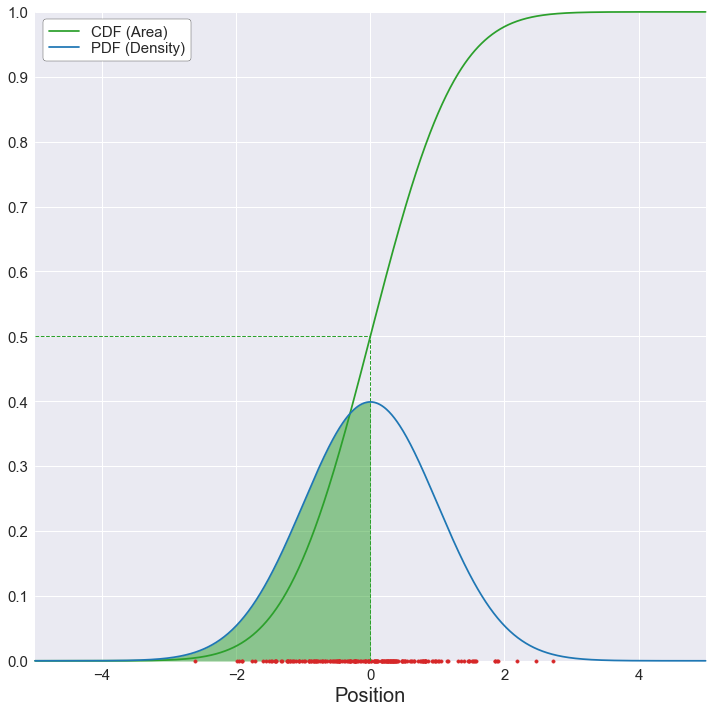

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
z = np.arange(-5, 5.01, 0.01)
z_minus = z[z<0]
ax.plot(z, cdf(z), label=r'CDF (Area)', color='tab:green', clip_on=False)
ax.plot(z, pdf(z), label=r'PDF (Density)', color='tab:blue', clip_on=False)
ax.vlines(0, 0, 0.5, linestyles='--', lw=1, color='tab:green')
ax.hlines(0.5, -5, 0, linestyles='--', lw=1, color='tab:green')
ax.fill_between(z_minus, 0, pdf(z_minus), color='tab:green', alpha=0.5)
ax.scatter(samples, np.zeros(len(samples)), marker='.', color='tab:red', clip_on=False)
ax.set_xlabel('Position')
ax.legend(**legend_opts, loc='upper left')
ax.set_xlim(-5, 5)
ax.set_ylim(-0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.tight_layout()
plt.show()
savefig(fig, 'cdf_pdf.png')

## Sampling from position to area

In [11]:
rng = np.random.RandomState(seed=42)
samples = rng.standard_normal(size=1000)
cumprobs = cdf(samples)

In [12]:
def update(i, fig, cdf_ax, density_ax, cumprob_ax, verbose=False):
    if verbose and i%100==0:
        print(i)
    fig.suptitle(f'Sample {i+1}', fontsize=20)
    sample, cumprob = samples[i], cumprobs[i]
    # Round sample and cumulative probability to put them to rounded bins for histogram
    rounded_sample, rounded_cumprob = np.floor(sample), np.floor(cumprob*10)/10
    
    # Update histogram of sampled Gaussian
    density_counts.setdefault(rounded_sample, 0)
    density_ax.add_artist(Rectangle((rounded_sample, density_counts[rounded_sample]), 1, 1, facecolor='tab:blue'))
    density_counts[rounded_sample] += 1
    
    # Update histogram of areas / cumulative probabilities
    cumprob_counts.setdefault(rounded_cumprob, 0)
    cumprob_ax.add_artist(Rectangle((cumprob_counts[rounded_cumprob], rounded_cumprob), 1, 0.1, facecolor='tab:green'))
    cumprob_counts[rounded_cumprob] += 1
    
    # Draw sampled point and sampled area onto CDF
    cdf_ax.scatter(sample, 1, marker='.', color='tab:blue', clip_on=False, zorder=11)
    cdf_ax.scatter(4, cumprob, marker='.', color='tab:green', clip_on=False, zorder=12)
    cdf_ax.hlines(cumprob, sample, 4, color='tab:green', linestyles=':', linewidth=1, alpha=0.5)
    cdf_ax.vlines(sample, cumprob, 1, color='tab:blue', linestyles=':', linewidth=1, alpha=0.5)

In [ ]:
fig = plt.figure(figsize=(10, 10))
grid = plt.GridSpec(2, 2)
z = np.arange(-4, 4.01, 0.01)
z_left = z[z<-1]

cdf_ax = fig.add_subplot(grid[1, 0])
cdf_ax.plot(z, cdf(z), color='tab:gray')
cdf_ax.set_xlim(-4, 4)
cdf_ax.set_ylim(0, 1)

pdf_ax = fig.add_subplot(grid[0, 1], frameon=True)
pdf_ax.patch.set_edgecolor('black') 
pdf_ax.plot(z, pdf(z), color='tab:gray')
pdf_ax.scatter(-1, 0, color='tab:blue', clip_on=False)
pdf_ax.vlines(-1, 0, pdf(-1), linestyles='--', color='tab:blue')
pdf_ax.fill_between(z_left, 0, pdf(z_left), color='tab:green', alpha=0.2)
pdf_ax.set_xlim(-4, 4)
pdf_ax.set_ylim(0, 0.41)
pdf_ax.set_facecolor('white')
pdf_ax.set_yticks([])
pdf_ax.set_xlabel('Density\nN(0, 1)', fontsize=15)
pdf_ax.xaxis.set_label_position('top') 

density_ax = fig.add_subplot(grid[0, 0], sharex=cdf_ax)
density_ax.set_ylim(0, 500)
density_ax.set_xlabel('Sample value (Position)', fontsize=15, color='tab:blue')
density_ax.set_ylabel('Count', fontsize=15)

cumprob_ax = fig.add_subplot(grid[1, 1], sharey=cdf_ax)
cumprob_ax.set_xlim(0, 120)
cumprob_ax.set_xticks(np.arange(0, 121, 15))
cumprob_ax.set_xlabel('Count', fontsize=15)
cumprob_ax.set_ylabel('Cumulative probability (Area)', fontsize=15, rotation=270, va='top', color='tab:green')

density_counts = {}
cumprob_counts = {}
anim = FuncAnimation(fig, lambda i: update(i, fig, cdf_ax, density_ax, cumprob_ax, verbose=True), 
                     frames=range(len(samples)), interval=50, repeat=True)
anim.save('../viz/inverse_cdf_anim.mp4', writer='ffmpeg')

## Integrate Gaussian PDF to find CDF

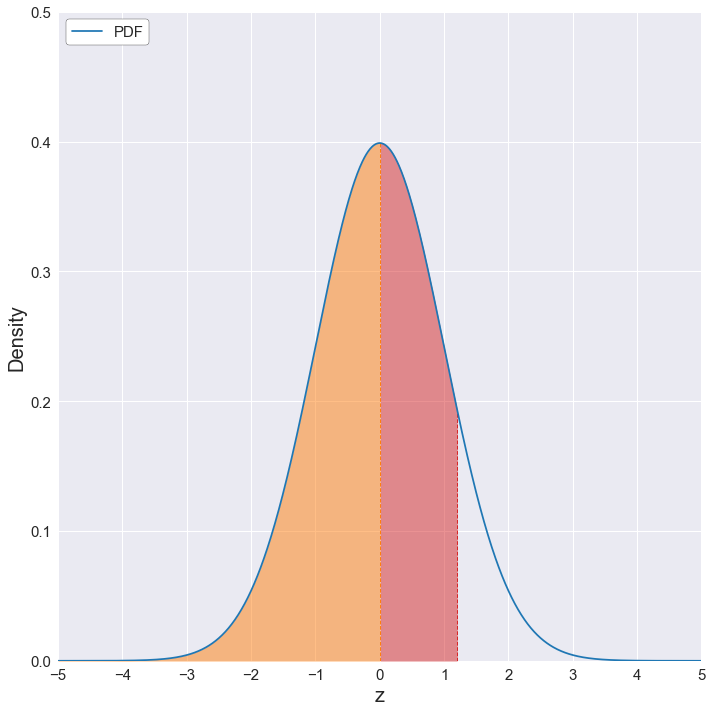

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

z = np.arange(-5, 5.01, 0.01)
z_left0 = z[z<0]

x = 1.2
z_0x = z[(z>0) & (z<x)]

ax.plot(z, pdf(z), label=r'PDF', color='tab:blue')
ax.vlines(0, 0, 1/sqrt(2*pi), linestyles='--', lw=1, color='tab:orange')
ax.fill_between(z_left0, 0, pdf(z_left0), color='tab:orange', alpha=0.5)
ax.vlines(x, 0, 1/sqrt(2*pi)*exp(-x**2/2), linestyles='--', lw=1, color='tab:red')
ax.fill_between(z_0x, 0, pdf(z_0x), color='tab:red', alpha=0.5)

ax.set_xlabel('z')
ax.set_ylabel('Density')
ax.legend(**legend_opts, loc='upper left')
ax.set_xlim(-5, 5)
ax.set_ylim(-0, 0.5)
ax.set_yticks(np.arange(0, 0.51, 0.1))
ax.set_xticks(np.arange(-5, 6, 1))

plt.tight_layout()
plt.show()
savefig(fig, 'cdf_areas.png')

# The inverse error function (erfinv)

## Approximate erfinv

Relationship between erf and erfinv:
* Both symmetric around 0
* erf(0) = 0 means erfinv(0) = 0

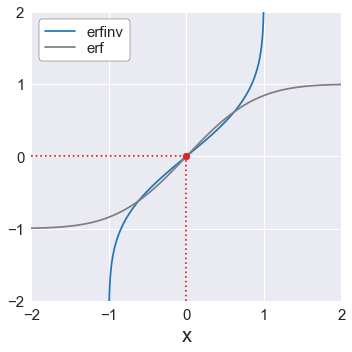

In [15]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(0-1, 1)
ax.set_ylim(-2, 2)
bs = np.arange(-0.9999, 1, 0.0001)
xs = erfinv(bs)

cs = np.arange(-2, 2, 0.0001)
es = erf(cs)
ax.set_xticks(np.arange(-2, 3, 1))
ax.set_xlabel('x')
ax.set_yticks(np.arange(-2, 3, 1))
ax.plot(bs, xs, color='tab:blue', label='erfinv')
ax.plot(cs, es, color='tab:gray', label='erf')

ax.hlines(0, -2, 0, linestyles=':', color='tab:red')
ax.vlines(0, -2, 0, linestyles=':', color='tab:red')
ax.scatter(0, 0, color='tab:red', zorder=10)
ax.legend(**legend_opts, loc='upper left')

plt.tight_layout()
savefig(fig, 'erf_erfinv.png')

## Taylor approximation of erfinv(x)

In [4]:
def update_P(P, n):
    '''Update polynomial for each term of Taylor series approximation of erfinv'''
    EP = [0] + P
    two_nEP = [2 * n * coeff for coeff in EP]
    dP = [power * coeff for power, coeff in enumerate(P)][1:]
    updated_P = [two_nEP_coeff + dP_coeff for two_nEP_coeff, dP_coeff in zip_longest(two_nEP, dP, fillvalue=0)]
    return updated_P

In [5]:
taylor_coeffs = [0, sqrt(pi)/2]   # First two coefficients
P = [0, 2]                        # Polynomial of second derivative
dE = sqrt(pi)/2                   # First derivative at x = 0
### Find Taylor coefficient for each term from x^2 to x^50
for n in range(2, 51):
    P_const = P[0]                # Constant term of polynomial
    taylor_coeff = (dE**n * P_const) / factorial(n)
    P = update_P(P, n)
    taylor_coeffs.append(taylor_coeff)

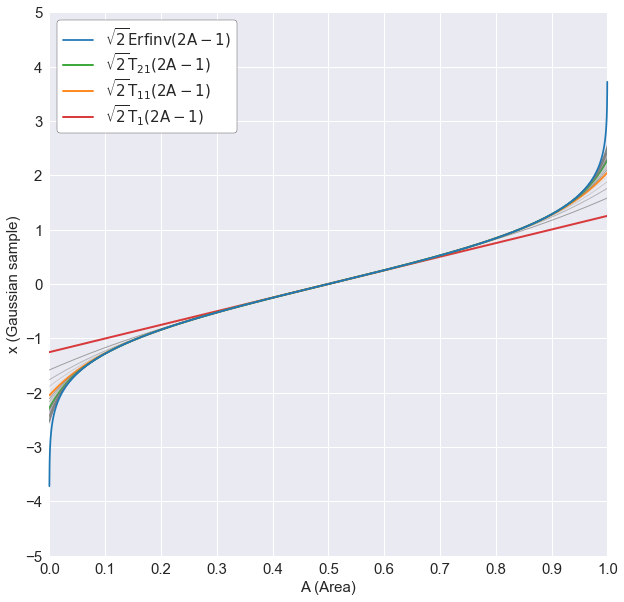

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
a = np.arange(0, 1.0001, 0.0001)
b = 2*a - 1
x = np.zeros(len(a))
color_dict = {1: 'tab:red', 11:'tab:orange', 21:'tab:green'}
label_dict = {1: '$\mathrm{\sqrt{2}{T_1(2A-1)}}$', 11: '$\mathrm{\sqrt{2}T_{11}(2A-1)}$', 21: '$\mathrm{\sqrt{2}T_{21}(2A-1)}$'}
lw_dict = {1: 2, 11: 2, 21: 2}

for power, coeff in enumerate(taylor_coeffs):
    x += sqrt(2) * (coeff * b**power)
    if power%2 != 0:
        ax.plot(a, x, color=color_dict.get(power, 'tab:gray'), lw=lw_dict.get(power, 1), alpha=(1-0.1*power), label=label_dict.get(power, '_nolegend_'))
ax.plot(a, sqrt(2) * erfinv(b), color='tab:blue', label='$\mathrm{\sqrt{2}Erfinv(2A-1)}$', clip_on=False)

ax.set_xlim(0, 1)
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_ylim(-5, 5)
ax.set_yticks(range(-5, 6))
ax.set_xlabel('A (Area)', fontsize=15)
ax.set_ylabel('x (Gaussian sample)', fontsize=15)

ax.legend(**legend_opts, loc='upper left')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], **legend_opts, loc='upper left')

savefig(fig, 'taylor_approx_erfinv.png')

# Use Taylor approximation to convert area back to Gaussian sample

Convert single area (using Taylor series of different powers: 1, 11, 21, as well as using scipy.special.erfinv)

In [7]:
area = 0.9
invcdf1 = InverseCDF(power=1)
invcdf11 = InverseCDF(power=11)
invcdf21 = InverseCDF(power=21)

invcdf1.calculate_sample(area), invcdf11.calculate_sample(area), invcdf21.calculate_sample(area), sqrt(2) * erfinv(2*area-1)

(1.0026513098524001,
 1.2740421698775237,
 1.2810928879786332,
 1.2815515655446004)

Convert 1000 areas (generated independently for x and y)

In [8]:
# Step 1: Sample 1000 independent left-side areas
# (independently for x and y coordinates)
area_xs = np.random.RandomState(seed=42).uniform(size=1000)
area_ys = np.random.RandomState(seed=24).uniform(size=1000)

# Step 2: Apply Taylor series approximation of inverse Gaussian CDF
invcdf21 = InverseCDF(power=21)

# Step 3: Generate Gaussian samples for x and y coordinates
gaussian_xs = invcdf21.calculate_sample(area_xs)
gaussian_ys = invcdf21.calculate_sample(area_ys)

The higher power the Taylor series approximation, the more blob-like the generated 2-D Gaussian samples become

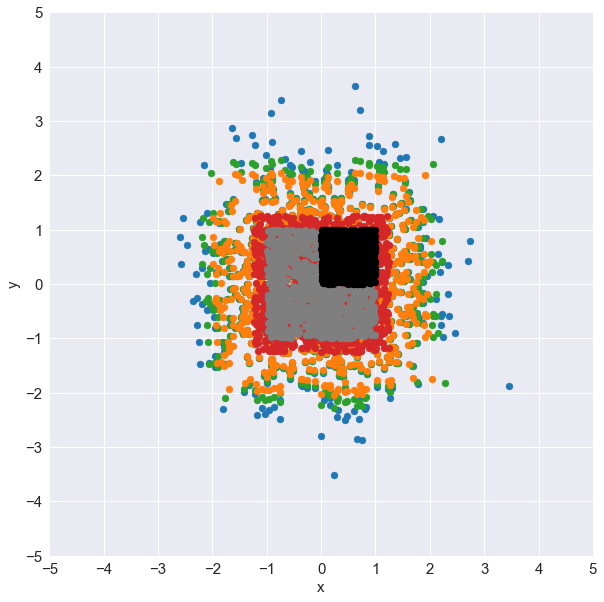

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(area_xs, area_ys, color='black', zorder=16, label='$\mathrm{A}$')
ax.scatter(2*area_xs-1, 2*area_ys-1, color='tab:gray', zorder=15, label='$\mathrm{2A-1}$')
ax.scatter(invcdf1.calculate_sample(area_xs), invcdf1.calculate_sample(area_ys), color='tab:red', zorder=14, label='$\mathrm{\sqrt{2}T_{1}(2A-1)}$')
ax.scatter(invcdf11.calculate_sample(area_xs), invcdf11.calculate_sample(area_ys), color='tab:orange', zorder=13, label='$\mathrm{\sqrt{2}T_{11}(2A-1)}$')
ax.scatter(invcdf21.calculate_sample(area_xs), invcdf21.calculate_sample(area_ys), color='tab:green', zorder=12, label='$\mathrm{\sqrt{2}T_{21}(2A-1)}$')
ax.scatter(sqrt(2)*erfinv(2*area_xs-1), sqrt(2)*erfinv(2*area_ys-1), color='tab:blue', zorder=11, label='$\mathrm{\sqrt{2}Erfinv(2A-1)}$')

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_xticks(range(-5, 6))
ax.set_yticks(range(-5, 6))
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15)
ax.set_aspect('equal')
# ax.legend(**legend_opts)

savefig(fig, 'taylor_approx_samples_nolegend.png')